In [ ]:
import ee
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-vertifysaptarshi')

In [ ]:
# Load the feature collections
# table = ee.FeatureCollection("projects/ee-vertifysaptarshi/assets/TelanganaSoilTesting_V2")
table = ee.FeatureCollection("projects/ee-vertifysaptarshi/assets/icraf_ph")
telangana = ee.FeatureCollection("projects/ee-vertifysaptarshi/assets/telangana_district")

In [ ]:
# Define the image collection and filter by date
dataset = ee.ImageCollection('COPERNICUS/S2') \
          .filterDate('2023-05-01', '2023-06-01')

In [ ]:
# Function to apply scaling factors
def apply_scale_factors(image):
    optical_bands = image.select(['B4', 'B3', 'B2']).multiply(0.0001)
    return image.addBands(optical_bands, None, True)

# Map the scaling function to the image collection
dataset = dataset.map(apply_scale_factors)

# Visualization parameters
visualization = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0.0,
    'max': 0.3,
}

# Create a mosaic of the image collection
l8_img = dataset.mosaic()

In [ ]:
# Extract bands
green = l8_img.select('B3').toFloat()
red = l8_img.select('B4').toFloat()
nir = l8_img.select('B8').toFloat()  # NIR band in Sentinel-2

# Prepare the indices
SI1 = green.multiply(red).sqrt().rename('SI1')
SI2 = green.pow(2).add(red.pow(2)).add(nir.pow(2)).sqrt().rename('SI2')
NDSI = nir.subtract(red).divide(nir.add(red)).rename('NDSI')
BI = red.pow(2).add(nir.pow(2)).sqrt().rename('BI')
NDVI = l8_img.normalizedDifference(['B8', 'B4']).rename('NDVI')  # NIR and Red bands in Sentinel-2
SRSI = NDVI.subtract(1).pow(2).add(SI1.pow(2)).sqrt().rename('SRSI')

l8_img = l8_img.addBands([SI1, SI2, NDSI, BI, SRSI])
l8_img = l8_img.select('SI1', 'SI2', 'NDSI', 'BI', 'SRSI')

In [ ]:
# Sample regions
training_data = l8_img.sampleRegions(
    collection=table,
    # properties=['Sample No', 'Soil pH', 'Soil pH Result'], #For WRMS
    properties=['Sample No', 'PH'], #For ICRAF
    scale=10
)

# Define the bands for regression
bands = ['SI1', 'SI2', 'NDSI', 'BI', 'SRSI']

# Define the target variable
target = 'PH'

In [ ]:
# Split data into training and validation sets
split = 0.9
training_partition = training_data.randomColumn('random').filter(ee.Filter.lt('random', split))
validation_partition = training_data.randomColumn('random').filter(ee.Filter.gte('random', split))

In [ ]:
# Convert training data to a pandas DataFrame
df = geemap.ee_to_df(training_data)

# Display the DataFrame
df

,BI,NDSI,PH,SI1,SI2,SRSI
0,3193.000011,0.999835,7.30,0.257059,3193.000021,0.257059
1,3336.000010,0.999848,7.65,0.250123,3336.000019,0.250123
2,3188.000011,0.999832,7.48,0.259470,3188.000021,0.259471
3,3021.000011,0.999832,7.72,0.249658,3021.000021,0.249658
4,3105.000010,0.999838,7.78,0.248083,3105.000020,0.248083
...,...,...,...,...,...,...
140,3397.000011,0.999838,5.13,0.260971,3397.000020,0.260971
141,3471.000009,0.999857,5.18,0.242777,3471.000017,0.242777
142,3064.000009,0.999845,5.23,0.229253,3064.000017,0.229253
143,3559.000009,0.999858,5.45,0.243493,3559.000017,0.243493


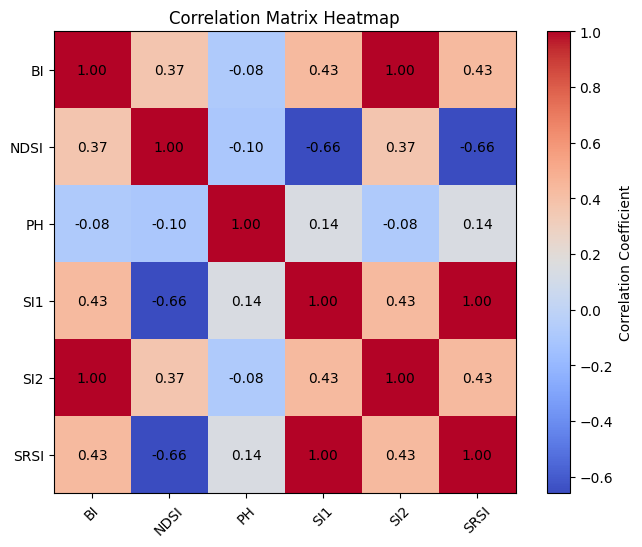

In [ ]:
# Calculate the correlation matrix
corr = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation Matrix Heatmap')

# Add annotation
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j, i, '{:.2f}'.format(corr.iloc[i, j]), ha='center', va='center', color='black')

plt.show()


In [ ]:
# Train the regressor
regressor = ee.Classifier.smileGradientTreeBoost(
    loss='LeastSquares',
    numberOfTrees=50,
    seed=20
).setOutputMode('REGRESSION')
regressor = ee.Classifier.smileRandomForest(numberOfTrees=100,
                                             seed=20).setOutputMode('REGRESSION')
# Train the model
trained_regressor = regressor.train(
    features=training_partition,
    classProperty=target,
    inputProperties=bands
)

In [ ]:
trained_regressor.schema()

In [ ]:
trained_regressor.explain()

In [ ]:
# Classify the training and validation partitions
train = training_partition.classify(trained_regressor)
val = validation_partition.classify(trained_regressor)

In [ ]:
# Convert training data to a pandas DataFrame
training_df = geemap.ee_to_df(train)

# Display the DataFrame
training_df.head()

,BI,NDSI,PH,SI1,SI2,SRSI,classification,random
0,3336.000010,0.999848,7.65,0.250123,3336.000019,0.250123,6.896767,0.301630
1,3188.000011,0.999832,7.48,0.259470,3188.000021,0.259471,7.160717,0.739691
2,3021.000011,0.999832,7.72,0.249658,3021.000021,0.249658,6.898167,0.192946
3,3061.000011,0.999831,7.71,0.252996,3061.000021,0.252996,7.134533,0.454169
4,3193.000011,0.999834,7.87,0.258179,3193.000021,0.258179,7.276483,0.775172


In [ ]:
# training_df['Soil pH Result'].unique()

In [ ]:
# Convert training data to a pandas DataFrame
validation_df = geemap.ee_to_df(val)

# Display the DataFrame
validation_df.head()

,BI,NDSI,PH,SI1,SI2,SRSI,classification,random
0,3193.000011,0.999835,7.30,0.257059,3193.000021,0.257059,7.138117,0.907355
1,3105.000010,0.999838,7.78,0.248083,3105.000020,0.248083,5.720233,0.926152
2,3375.000009,0.999855,5.26,0.238173,3375.000017,0.238173,6.046233,0.913827
3,3415.000011,0.999837,5.25,0.262230,3415.000020,0.262230,5.803800,0.944643
4,3383.000006,0.999882,5.87,0.206685,3383.000013,0.206685,5.952950,0.909256


In [ ]:
tr = train.getInfo()['features']
print(len(tr))
print(tr)

arr=[]
for i in tr:
  # arr.append([i['properties']['Soil pH'],i['properties']['classification']]) #For WRMS
  arr.append([i['properties']['PH'],i['properties']['classification']]) #For ICRAF


print(arr)

import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
data = np.array(arr)

# Separate actual and predicted values
actual_values = data[:, 0]
predicted_values = data[:, 1]

# Calculate R2 score
r2 = r2_score(actual_values, predicted_values)

# Calculate RMSE
rmse = mean_squared_error(actual_values, predicted_values, squared=False)

print('R2 score:', r2)
print('RMSE:', rmse)


124
[{'type': 'Feature', 'geometry': None, 'id': '00000000000000000070_0', 'properties': {'BI': 3336.0000096544427, 'NDSI': 0.9998478293418884, 'PH': 7.650000095367432, 'SI1': 0.25012337206749696, 'SI2': 3336.0000187614946, 'SRSI': 0.25012341834189233, 'classification': 6.896766707102457, 'random': 0.30163019605245767}}, {'type': 'Feature', 'geometry': None, 'id': '00000000000000000071_0', 'properties': {'BI': 3188.000011247936, 'NDSI': 0.999832034111023, 'PH': 7.480000019073486, 'SI1': 0.25947045919069256, 'SI2': 3188.000021160414, 'SRSI': 0.2594705135724939, 'classification': 7.160716623862586, 'random': 0.7396914487854083}}, {'type': 'Feature', 'geometry': None, 'id': '00000000000000000072_0', 'properties': {'BI': 3021.0000107031597, 'NDSI': 0.9998316764831543, 'PH': 7.71999979019165, 'SI1': 0.24965762800749097, 'SI2': 3021.000020645896, 'SRSI': 0.249657684762378, 'classification': 6.898166599273682, 'random': 0.1929456132752717}}, {'type': 'Feature', 'geometry': None, 'id': '000000

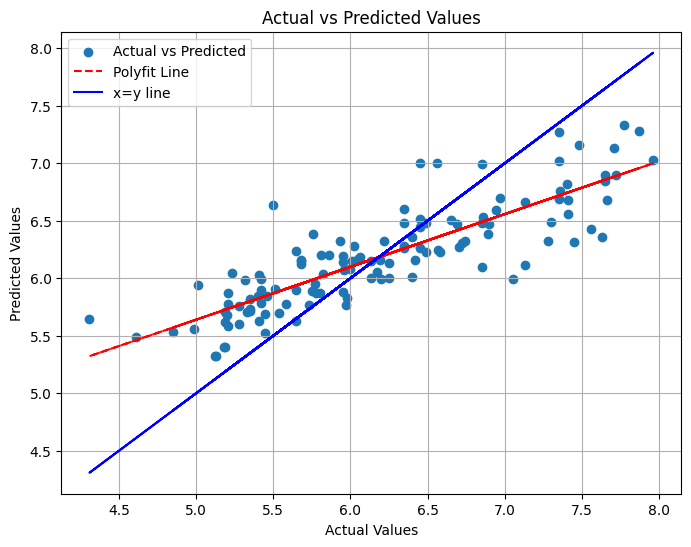

In [ ]:
# Convert the array into a DataFrame
df = pd.DataFrame(data, columns=['Actual', 'Predicted'])

# Plot x vs y graph
plt.figure(figsize=(8, 6))

# Scatter plot
plt.scatter(df['Actual'], df['Predicted'], label='Actual vs Predicted')

# Add a polynomial fit line
z = np.polyfit(df['Actual'], df['Predicted'], 1)
p = np.poly1d(z)
plt.plot(df['Actual'], p(df['Actual']), 'r--', label='Polyfit Line')

# Add x=y line
plt.plot(df['Actual'], df['Actual'], 'b-', label='x=y line')

# Labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [ ]:
tr = val.getInfo()['features']
print(len(tr))
print(tr)

arr=[]
for i in tr:
  # arr.append([i['properties']['Soil pH'],i['properties']['classification']]) #For WRMS
  arr.append([i['properties']['PH'],i['properties']['classification']]) #For ICRAF

print(arr)

import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
data = np.array(arr)

# Separate actual and predicted values
actual_values = data[:, 0]
predicted_values = data[:, 1]

# Calculate R2 score
r2 = r2_score(actual_values, predicted_values)

# Calculate RMSE
rmse = mean_squared_error(actual_values, predicted_values, squared=False)

print('R2 score:', r2)
print('RMSE:', rmse)


21
[{'type': 'Feature', 'geometry': None, 'id': '0000000000000000006f_0', 'properties': {'BI': 3193.000010913874, 'NDSI': 0.9998346567153931, 'PH': 7.300000190734863, 'SI1': 0.2570587424086405, 'SI2': 3193.00002072441, 'SRSI': 0.25705879558710293, 'classification': 7.138116621573768, 'random': 0.9073550273501498}}, {'type': 'Feature', 'geometry': None, 'id': '00000000000000000073_0', 'properties': {'BI': 3105.0000101450873, 'NDSI': 0.9998383522033691, 'PH': 7.78000020980835, 'SI1': 0.24808304083429136, 'SI2': 3105.0000198267358, 'SRSI': 0.2480830935071508, 'classification': 5.720233393510183, 'random': 0.9261519234129367}}, {'type': 'Feature', 'geometry': None, 'id': '0000000000000000002a_0', 'properties': {'BI': 3375.0000088418496, 'NDSI': 0.9998552203178406, 'PH': 5.260000228881836, 'SI1': 0.23817316715363707, 'SI2': 3375.0000168295296, 'SRSI': 0.23817321114562956, 'classification': 6.046233323415123, 'random': 0.9138269413918909}}, {'type': 'Feature', 'geometry': None, 'id': '000000

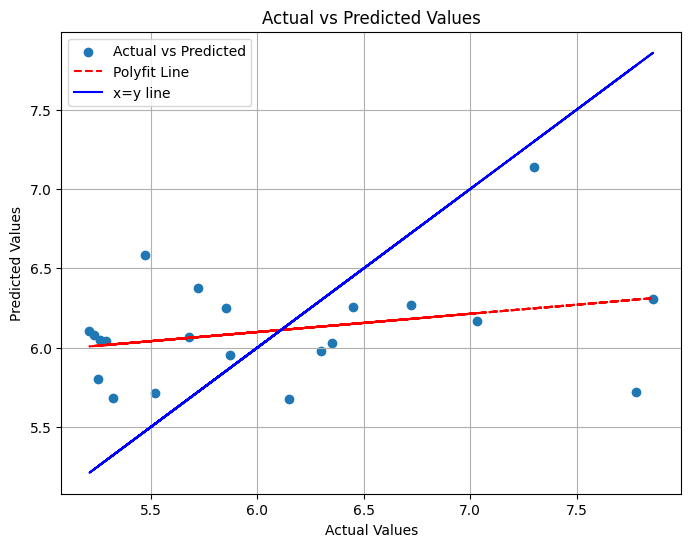

In [ ]:
# Convert the array into a DataFrame
df = pd.DataFrame(data, columns=['Actual', 'Predicted'])

# Plot x vs y graph
plt.figure(figsize=(8, 6))

# Scatter plot
plt.scatter(df['Actual'], df['Predicted'], label='Actual vs Predicted')

# Add a polynomial fit line
z = np.polyfit(df['Actual'], df['Predicted'], 1)
p = np.poly1d(z)
plt.plot(df['Actual'], p(df['Actual']), 'r--', label='Polyfit Line')

# Add x=y line
plt.plot(df['Actual'], df['Actual'], 'b-', label='x=y line')

# Labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()

# Show plot
plt.grid(True)
plt.show()